In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
import itertools

from scipy.stats import randint
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
## Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [21]:
dataset = pd.read_csv(r"G:\Machine Learning\git_code\data\time-series\airline-passengers.csv",
                 infer_datetime_format=True, parse_dates=['Month'], na_values=['nan','?'],
                 index_col=['Month'])

In [22]:
dataset.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


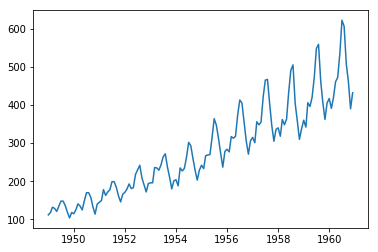

In [23]:
plt.plot(dataset)

In [29]:
df = dataset
ds = dataset.values
dataset = ds.astype('float32')

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [31]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

96 48


In [34]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [35]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [36]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((94, 1), (94,), (46, 1), (46,))

In [45]:
trainX[0], trainY[0]

(array([0.01544401], dtype=float32), 0.027027026)

In [47]:
# reshape input to be [samples, timesteps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [48]:
trainX.shape

(94, 1, 1)

In [51]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0495
Epoch 2/100
 - 0s - loss: 0.0242
Epoch 3/100
 - 0s - loss: 0.0189
Epoch 4/100
 - 0s - loss: 0.0175
Epoch 5/100
 - 0s - loss: 0.0165
Epoch 6/100
 - 0s - loss: 0.0155
Epoch 7/100
 - 0s - loss: 0.0146
Epoch 8/100
 - 0s - loss: 0.0137
Epoch 9/100
 - 0s - loss: 0.0127
Epoch 10/100
 - 0s - loss: 0.0118
Epoch 11/100
 - 0s - loss: 0.0109
Epoch 12/100
 - 0s - loss: 0.0099
Epoch 13/100
 - 0s - loss: 0.0091
Epoch 14/100
 - 0s - loss: 0.0081
Epoch 15/100
 - 0s - loss: 0.0073
Epoch 16/100
 - 0s - loss: 0.0065
Epoch 17/100
 - 0s - loss: 0.0058
Epoch 18/100
 - 0s - loss: 0.0051
Epoch 19/100
 - 0s - loss: 0.0045
Epoch 20/100
 - 0s - loss: 0.0039
Epoch 21/100
 - 0s - loss: 0.0035
Epoch 22/100
 - 0s - loss: 0.0031
Epoch 23/100
 - 0s - loss: 0.0028
Epoch 24/100
 - 0s - loss: 0.0026
Epoch 25/100
 - 0s - loss: 0.0024
Epoch 26/100
 - 0s - loss: 0.0023
Epoch 27/100
 - 0s - loss: 0.0022
Epoch 28/100
 - 0s - loss: 0.0022
Epoch 29/100
 - 0s - loss: 0.0021
Epoch 30/100
 - 0s - lo

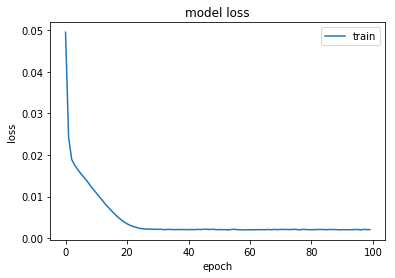

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [53]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [54]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [58]:
import math
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.33 RMSE
Test Score: 49.48 RMSE


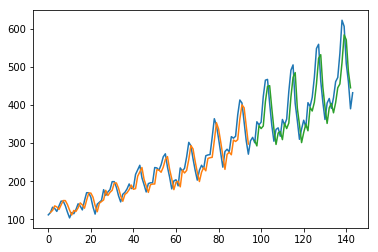

In [60]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()